<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
import math

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm

from ipywidgets import *
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

### Loading, EDA and Cleaning the Data

In [4]:
# Loading the data from the CSV file

house = pd.read_csv('./housing.csv')

In [5]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# Checking all the column names

house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
# Checking the different zones within the data set

print('Here are the unique zones:', house['MSZoning'].unique())

Here are the unique zones: ['RL' 'RM' 'C (all)' 'FV' 'RH']


In [8]:
# Removing the commercial zoned buildings and leaving only the redidential zoned builidngs

non_residential = house[house['MSZoning'] == 'C (all)'].index
house.drop(non_residential, inplace=True)

In [9]:
# Catergorising the features into fixed versus renovatable

house_fixed = house[['SalePrice', 'MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
                     'LandContour','Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
                     'Condition2','BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
                     'Foundation', 'BsmtQual','BsmtCond', 'BsmtExposure', 'TotalBsmtSF', '1stFlrSF',
                     '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                     'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType',
                     'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                     '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscFeature','MiscVal', 'MoSold', 'YrSold',
                     'SaleCondition']]

house_renovatable = house[['YrSold', 'OverallQual', 'OverallCond', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                           'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtFinType1', 'BsmtFinSF1',
                           'BsmtFinType2','BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir',
                           'Electrical', 'LowQualFinSF', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
                           'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC','Fence']]

In [10]:
house_fixed.dtypes

SalePrice          int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageType        object
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64


In [11]:
# Capturing all the numercial (float and int) from the house fixed dataframe

house_fixed_numerical = house_fixed.select_dtypes(include=['float64', 'int64'])
house_fixed_numerical.head()

,SalePrice,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,208500,60,65.0,8450,2003,2003,856,856,854,1710,...,548,0,61,0,0,0,0,0,2,2008
1,181500,20,80.0,9600,1976,1976,1262,1262,0,1262,...,460,298,0,0,0,0,0,0,5,2007
2,223500,60,68.0,11250,2001,2002,920,920,866,1786,...,608,0,42,0,0,0,0,0,9,2008
3,140000,70,60.0,9550,1915,1970,756,961,756,1717,...,642,0,35,272,0,0,0,0,2,2006
4,250000,60,84.0,14260,2000,2000,1145,1145,1053,2198,...,836,192,84,0,0,0,0,0,12,2008


In [12]:
# As I may be using a heatmap many times I will use this function.

def heatmap(df):
    corrs = df.corr()
    fig, ax = plt.subplots(figsize=(40,40))
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    title = 'Heatmap'
    ax = sns.heatmap(corrs, mask=mask, annot=True, fmt='.2f', annot_kws={'size':18},
                     cmap='RdBu_r', center=0, vmin=-1, vmax=1, cbar_kws={'shrink': 0.8})
    ax.set_title(title, fontsize=28)
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=20, rotation=60)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=20, rotation=0)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=20) 
    plt.show() 

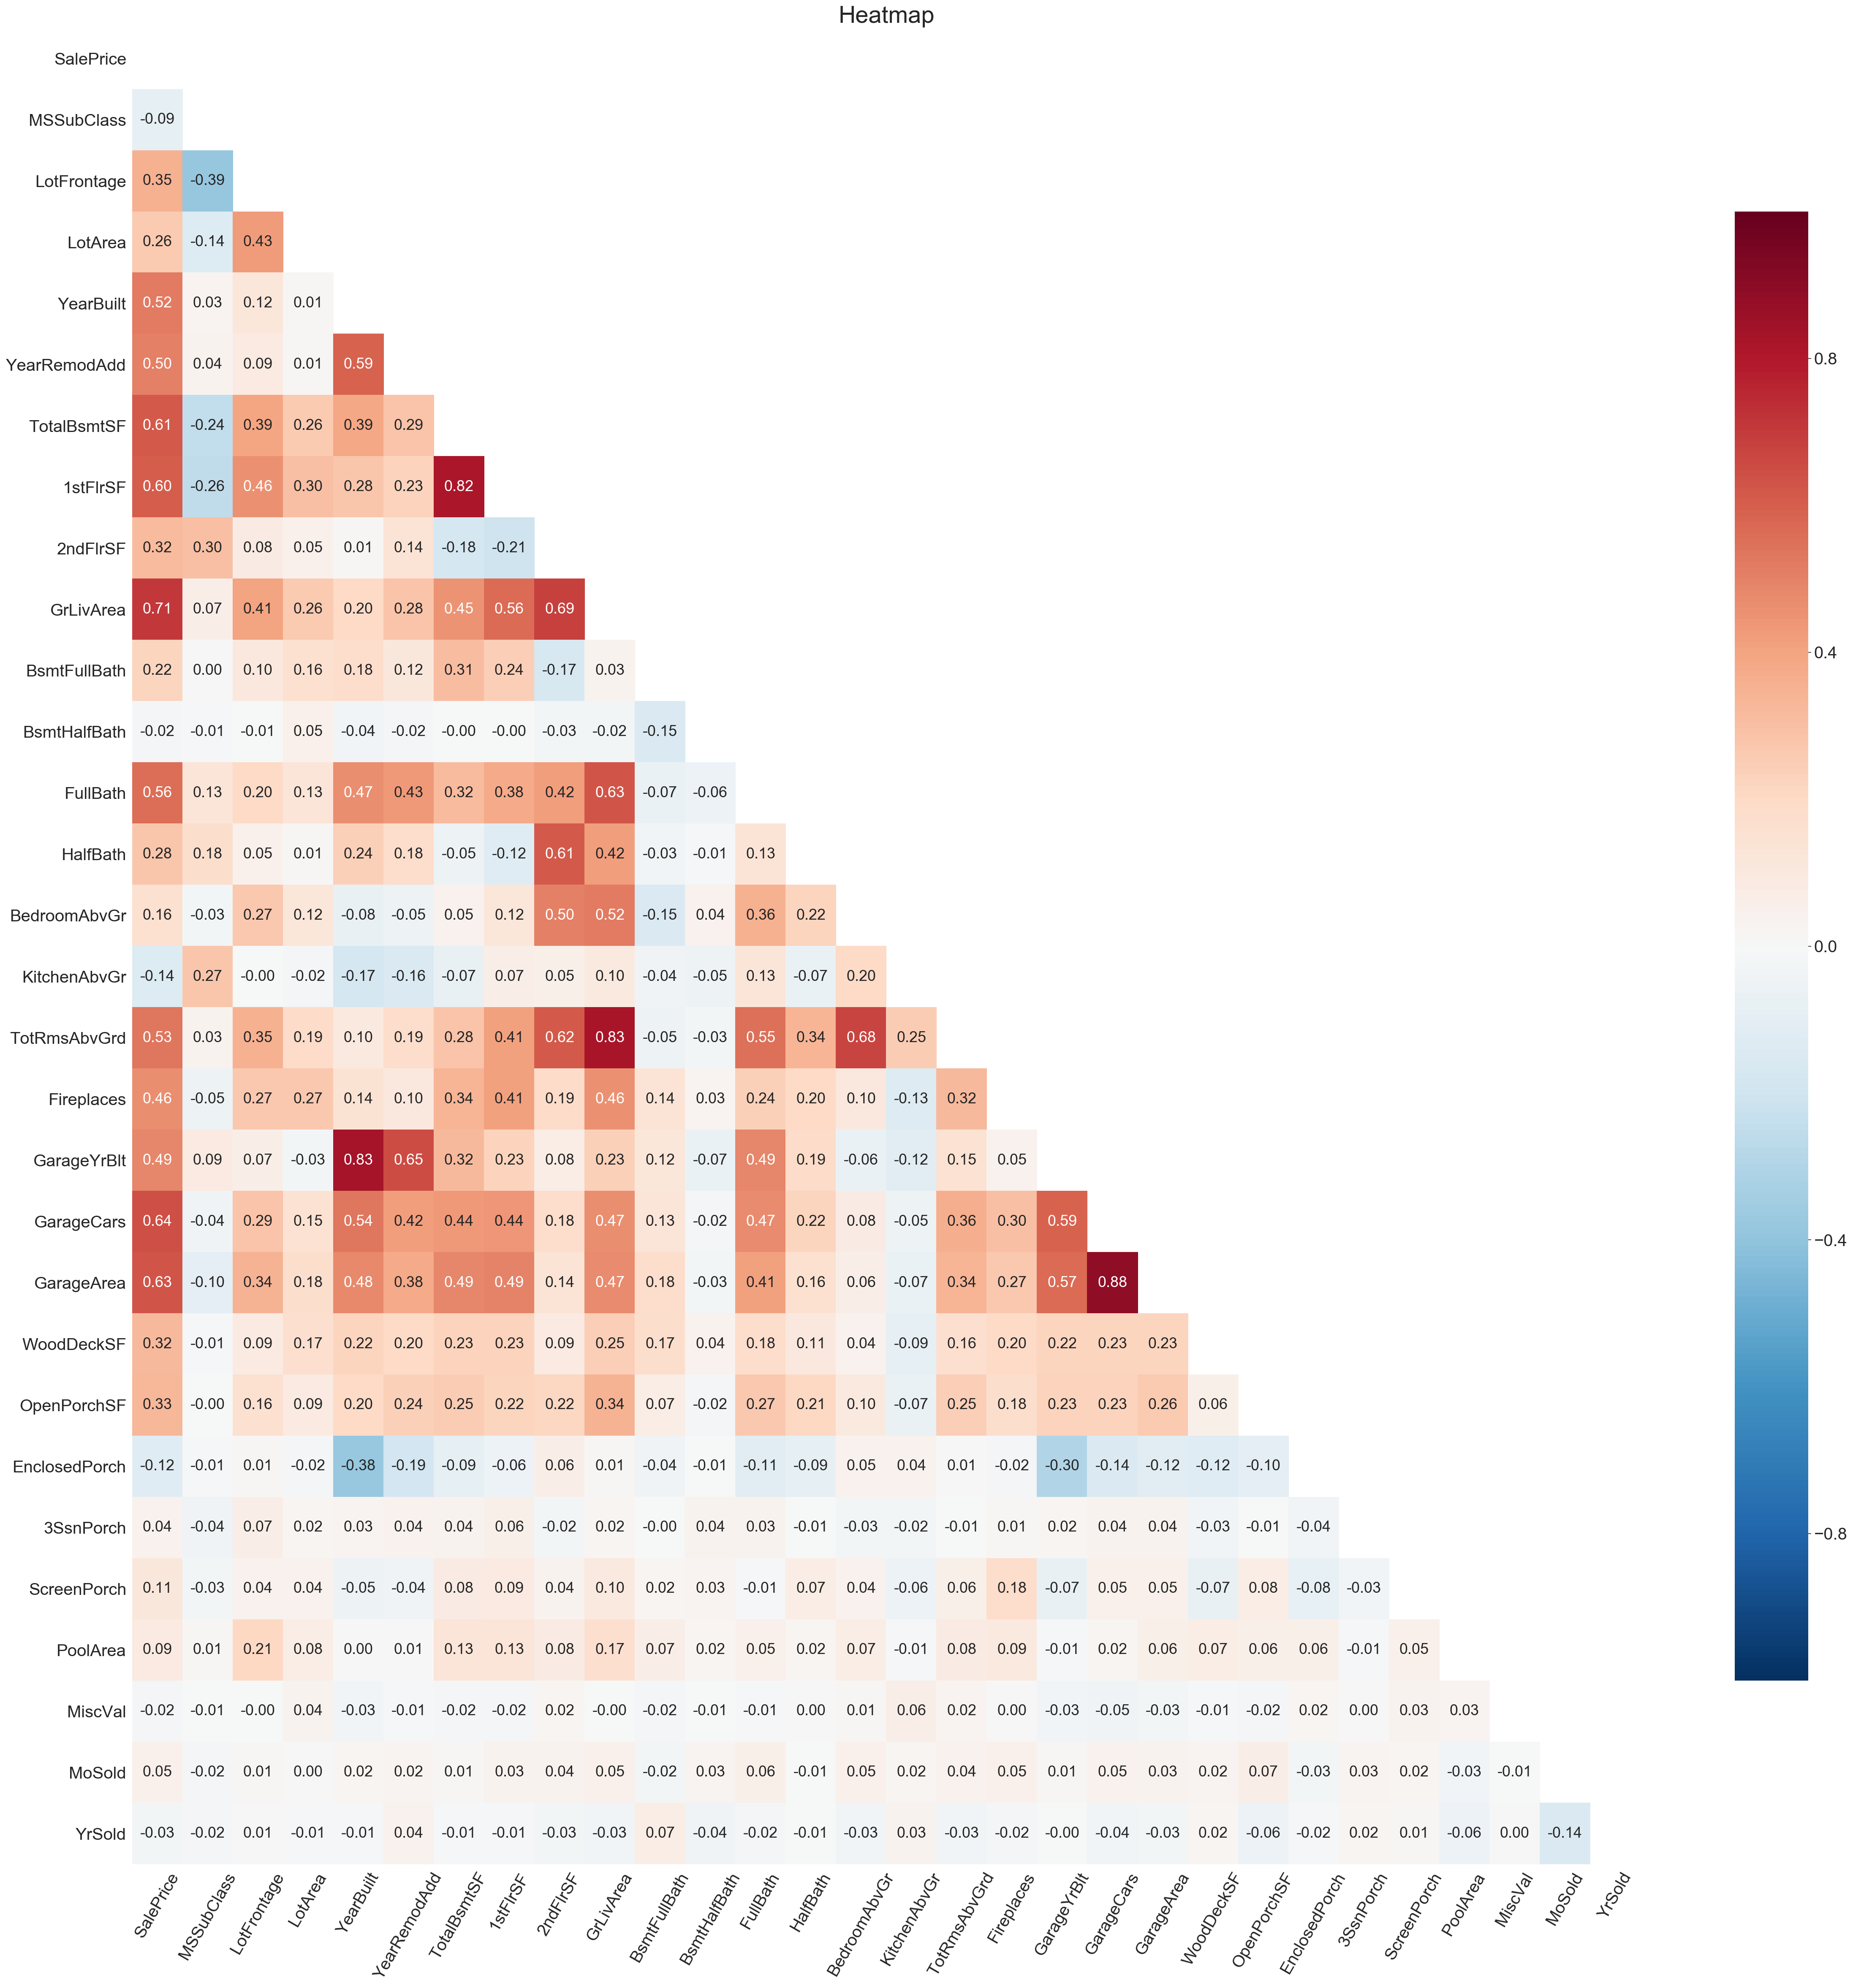

In [13]:
heatmap(house_fixed_numerical)

In [14]:
# From the analysis above I will drop 1stFlSF (1st Floor SqF) as it is highly correlated with the Basement SqF.
# I will also drop Garage Area as it is correlated with Garage Cars.

house_fixed.drop(columns=['1stFlrSF', 'GarageArea'], inplace=True)

In [15]:
house_renovatable.dtypes

YrSold            int64
OverallQual       int64
OverallCond       int64
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
MasVnrArea      float64
ExterQual        object
ExterCond        object
BsmtFinType1     object
BsmtFinSF1        int64
BsmtFinType2     object
BsmtFinSF2        int64
BsmtUnfSF         int64
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
LowQualFinSF      int64
KitchenQual      object
Functional       object
FireplaceQu      object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
dtype: object

In [16]:
# Capturing all the numercial (float and int) from the house fixed dataframe

house_renovatable_numerical = house_renovatable.select_dtypes(include=['float64', 'int64'])
house_renovatable_numerical.head()

,YrSold,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,LowQualFinSF
0,2008,7,5,196.0,706,0,150,0
1,2007,6,8,0.0,978,0,284,0
2,2008,7,5,162.0,486,0,434,0
3,2006,7,5,0.0,216,0,540,0
4,2008,8,5,350.0,655,0,490,0


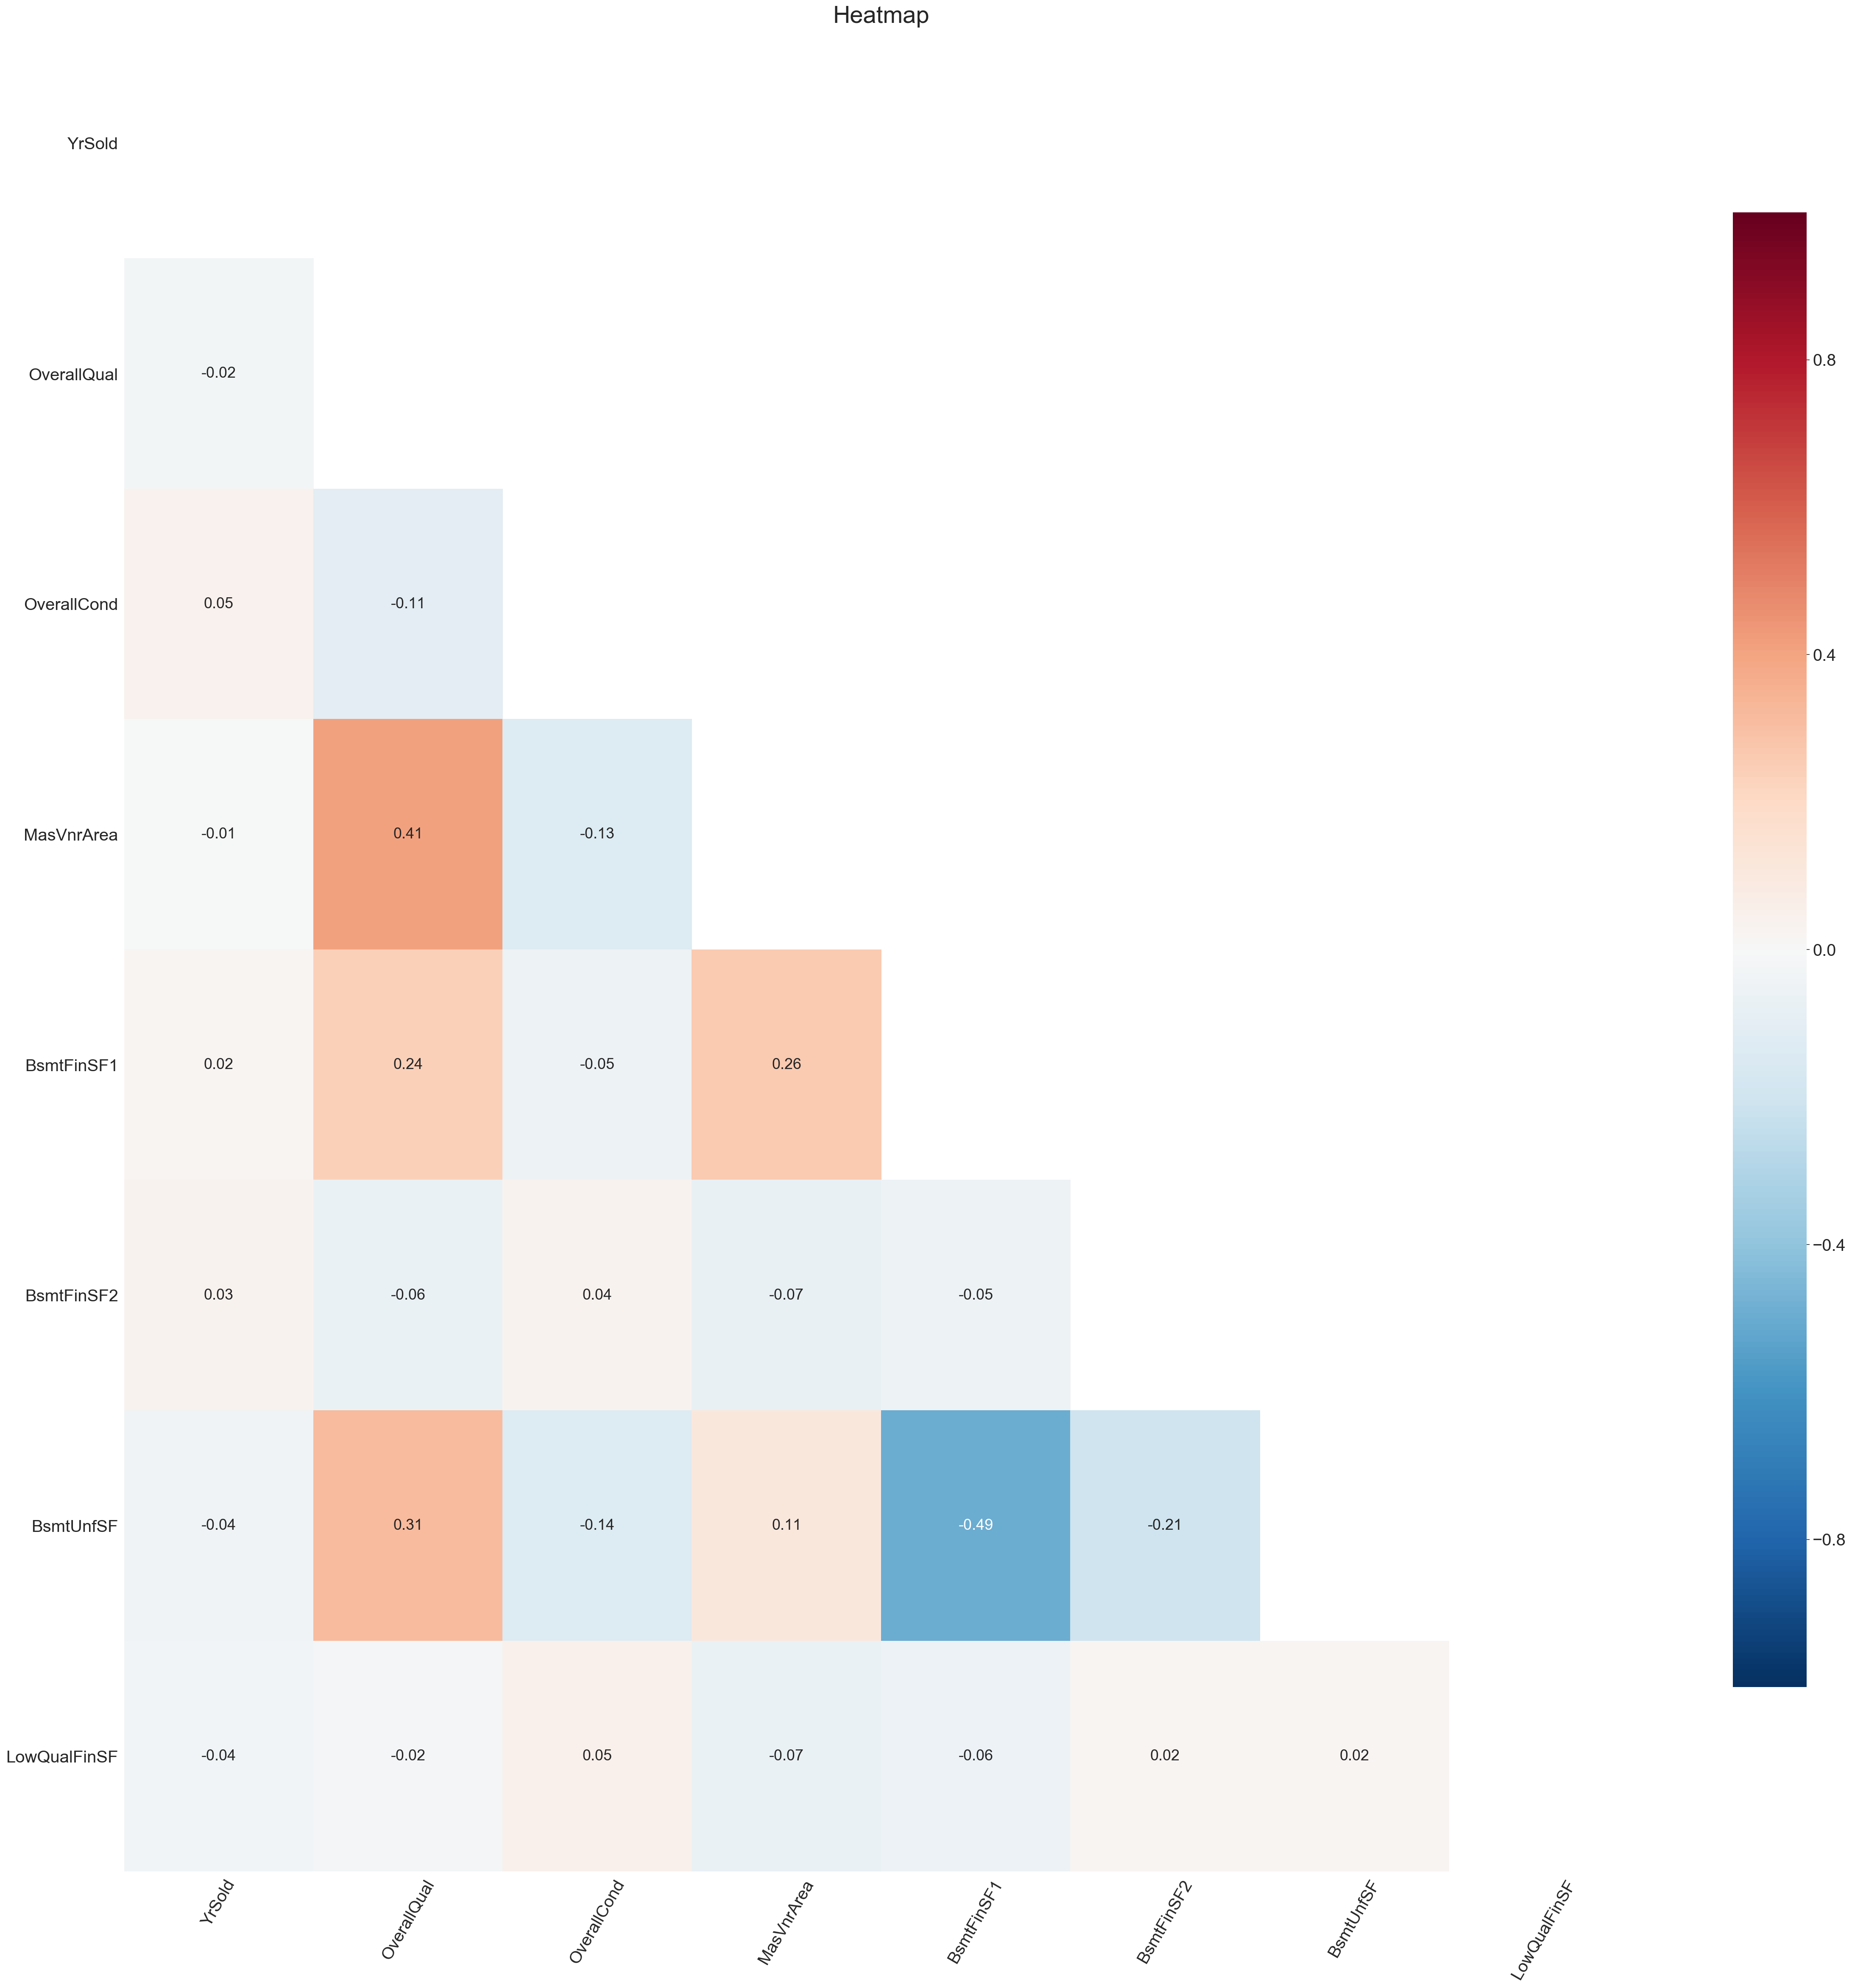

In [17]:
heatmap(house_renovatable_numerical)

In [18]:
# As none are highly correlated I will keep them all in for anaylsis

In [19]:
# Here I am splitting out the categorical varibales in each of the dataframes using the get dummies function.

house_fixed = pd.get_dummies(house_fixed, drop_first=True)
house_renovatable = pd.get_dummies(house_renovatable, drop_first=True)

In [20]:
# For the Lot Frontage I will impute the median values over the Nan values

for col in ['LotFrontage']:
    house_fixed[col].fillna(house_fixed[col].median(), inplace=True)

In [21]:
# As the MasVnrArea: (Masonry veneer area in square feet) im going to asumme Nan means none so will impute a zero.

for col in ['MasVnrArea']:
    house_renovatable[col].fillna(0, inplace=True)

In [22]:
# As there are many missing values and this is correlated with the Garage Size I will drop the column.

house_fixed.drop(['GarageYrBlt'], inplace=True, axis=1)

In [23]:
# Final check to see if there are any null values

house_fixed.isnull().sum().sum()

0

### Spliting the Data into Test and Train

In [24]:
# Splitting the data into a test and train data set based on the year sold

house_fixed_train = house_fixed[house_fixed['YrSold'] != 2010]
house_fixed_test = house_fixed[house_fixed['YrSold'] == 2010]

In [25]:
# Creating a test and train y

y_test = house_fixed_test['SalePrice']
y_train = house_fixed_train['SalePrice']

In [26]:
# Creating a test and train X

X_test = house_fixed_test.drop(columns=['SalePrice'])
X_train = house_fixed_train.drop(columns=['SalePrice'])

In [27]:
# Checking the shape of my dataframe and series

print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)

(172, 123)
(1278, 123)
(172,)
(1278,)


### Standerdising the Data

In [28]:
# Here I am using the Standard Scalar to standerdsie my data

ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.fit_transform(X_test)

### Creating and Training a Linear Model

In [242]:
# I am using the Linear Regression model from SK Learn

linear = LinearRegression()

In [243]:
# I am fitting the model with the training data

linear.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [244]:
# Here I will capture an array for my predicted y values from my training data

y_pred_linear_train = linear.predict(X_train)
y_pred_linear_train

array([202568.05412361, 197709.06914648, 212847.14390212, ...,
       209453.56166847, 178092.77796775, 137397.61384099])

Text(0.5, 1.0, 'Training Set: Measured vs Predicted')

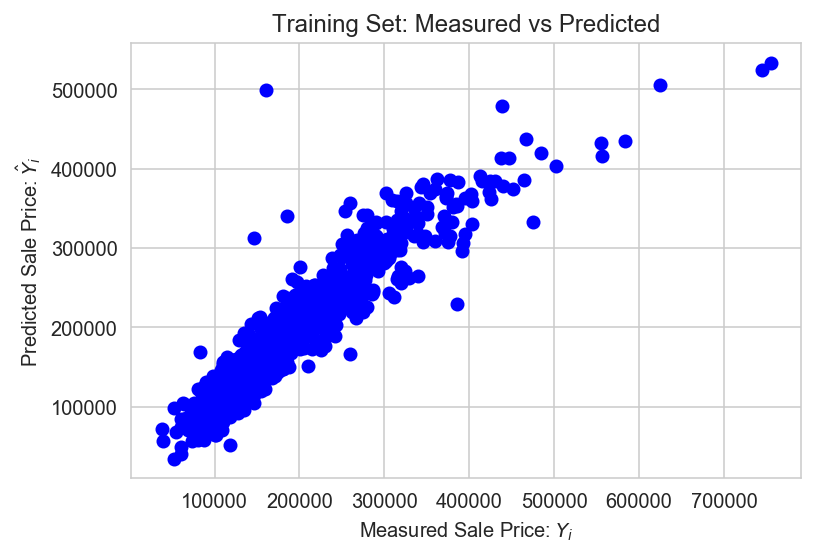

In [245]:
# Here is a scatter plot for the measured versus predicted sale prices from my training data

plt.scatter(y_train, y_pred_linear_train, color='blue')

plt.xlabel('Measured Sale Price: $Y_i$')
plt.ylabel('Predicted Sale Price: $\hat{Y}_i$')

plt.title('Training Set: Measured vs Predicted')

In [246]:
# Here is the score of my model

r2_linear_train = linear.score(X_train, y_train)
r2_linear_train

0.8689371358321687

In [247]:
# Here is the RMSE of the training data

rmse_linear_train = np.sqrt(mean_squared_error(y_train, y_pred_linear_train))
rmse_linear_train

28623.3212341965

### Testing the Model with the Test Data

In [248]:
# Here I am adding my testing data to the model and capturing the predictions in an array

y_pred_linear_test = linear.predict(X_test)

Text(0.5, 1.0, 'Test Set: Measured vs Predicted')

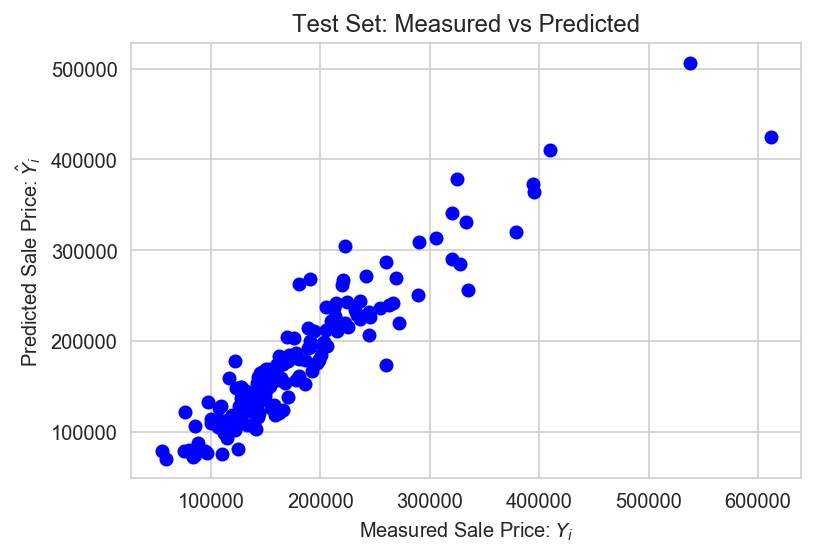

In [249]:
# Here is a scatterr plot for the measured versus predicted sale prices from my test data

plt.scatter(y_test, y_pred_linear_test, color='blue')

plt.xlabel('Measured Sale Price: $Y_i$')
plt.ylabel('Predicted Sale Price: $\hat{Y}_i$')

plt.title('Test Set: Measured vs Predicted')

In [250]:
# Here is the score from my test data

r2_linear_test = linear.score(X_test, y_test)
r2_linear_test

0.8707603238630222

In [251]:
# Here is the RMSE from the test data

rmse_linear_test = np.sqrt(mean_squared_error(y_test, y_pred_linear_test))
rmse_linear_test

28664.057651378338

In [252]:
# Here is the baseline to compare the RMSE

meanprice = y_train.mean()
nullprediction = [meanprice for i in range(len(y_test))]
baseline = np.sqrt(mean_squared_error(y_test,  nullprediction))
baseline

79783.25139454626

### Trying Lasso to see the Results

In [253]:
# Here Im trying Lasso with the CV 

lasso = LassoCV(cv=5)
lasso.fit(X_train_ss, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [254]:
# Here is the Lasso score on the training data

lasso.score(X_train_ss, y_train)

0.8601162780050576

In [255]:
# Here is the score on my test data

r2_lasso_test = lasso.score(X_test_ss, y_test)
r2_lasso_test

0.8833834616296637

In [256]:
# Here I am adding my testing data to the model and capturing the predictions in an array

y_pred_lasso_test = lasso.predict(X_test_ss)

In [257]:
# Here is the RMSE after Lasso

rmse_lasso_test = np.sqrt(mean_squared_error(y_test, y_pred_lasso_test))
rmse_lasso_test

27228.255110031867

Text(0.5, 1.0, 'Test Set: Measured vs Predicted')

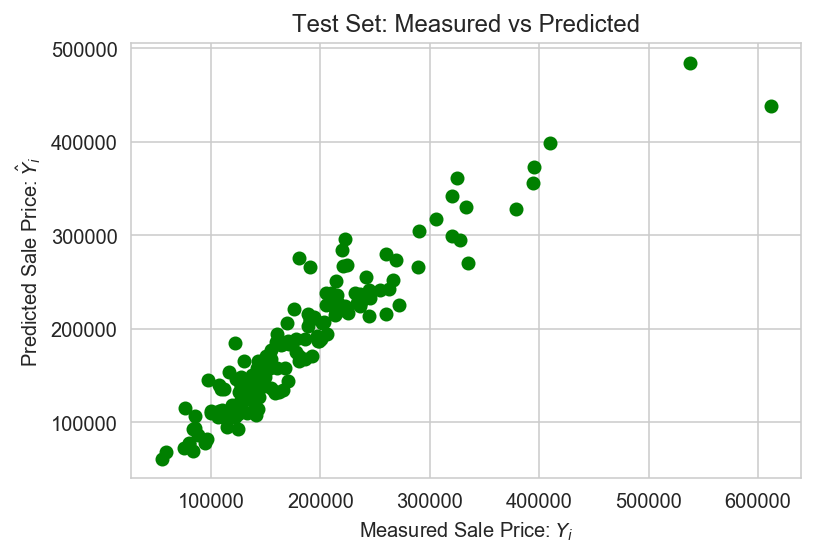

In [258]:
# Plot predictions for test data from optimum lasso model vs actual sale prices

y_pred_lasso_test = lasso.predict(X_test_ss)

plt.scatter(y_test, y_pred_lasso_test, color='green')

plt.xlabel('Measured Sale Price: $Y_i$')
plt.ylabel('Predicted Sale Price: $\hat{Y}_i$')

plt.title('Test Set: Measured vs Predicted')

In [259]:
# Creating a dataframe with predictor coefficients for optimum Lasso model

lasso_coeffs = pd.DataFrame({'features': X_train.columns,
                             'coef': lasso.coef_,
                             'abs_coef': np.abs(lasso.coef_)})

lasso_coeffs.sort_values('abs_coef', inplace=True, ascending=False)

In [260]:
# Here are the largest and most important coefficients

lasso_coeffs.head(20)

,features,coef,abs_coef
7,GrLivArea,27990.198885,27990.198885
102,BsmtQual_Gd,-13401.634151,13401.634151
103,BsmtQual_TA,-12186.269849,12186.269849
56,Neighborhood_NridgHt,11988.902321,11988.902321
55,Neighborhood_NoRidge,10176.572742,10176.572742
16,GarageCars,8032.792706,8032.792706
62,Neighborhood_StoneBr,7494.385891,7494.385891
4,YearRemodAdd,7014.987828,7014.987828
3,YearBuilt,6447.482003,6447.482003
5,TotalBsmtSF,5946.575602,5946.575602


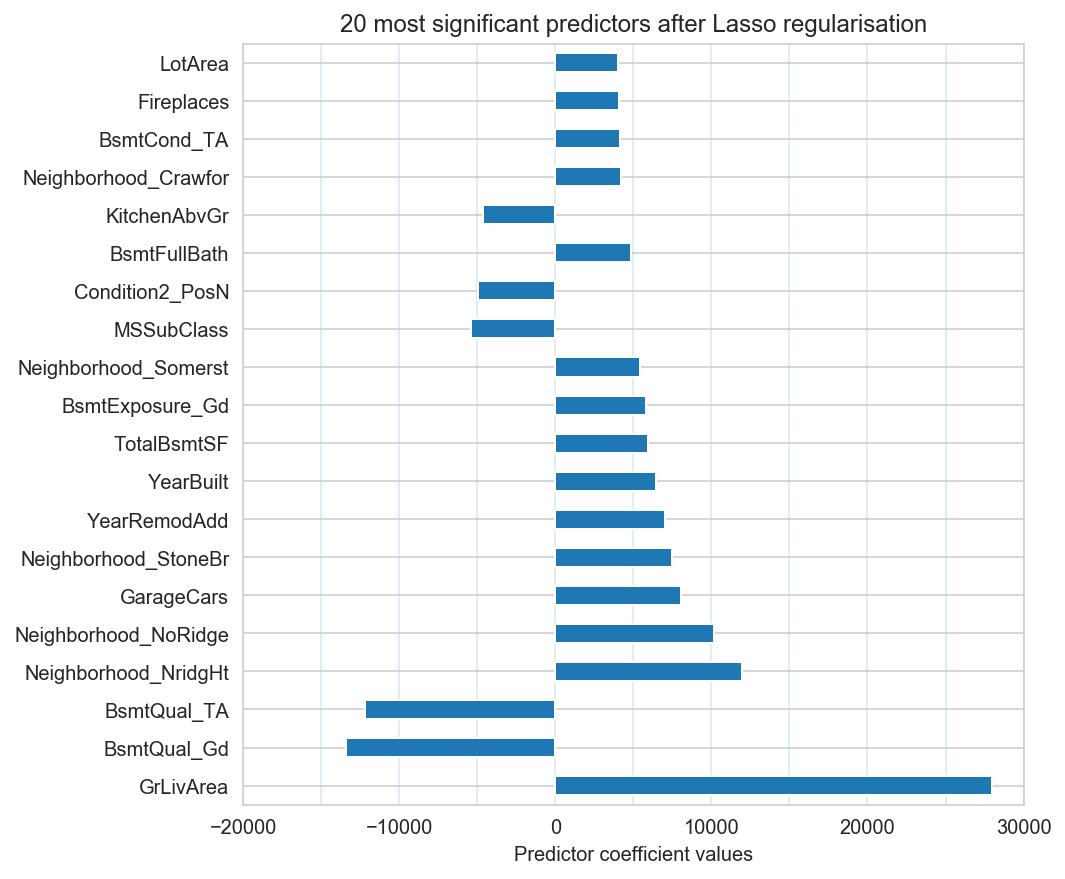

In [261]:
# Here I will graph the largest and most important coefficients

fig, ax = plt.subplots(figsize=(7,7))
title = '20 most significant predictors after Lasso regularisation'
lasso_coeffs.coef[:20].plot(kind='barh', ax=ax)
ax.set_yticklabels(lasso_coeffs.features[:20].values)
ax.set_xlabel('Predictor coefficient values')
ax.set_title(title)

ax.xaxis.grid(True, linestyle='-', which='both', color='lightblue', alpha=0.5)
ax.set_xticks(range(-20000, 30000, 5000), minor=True)
plt.show()

### Trying Ridge Regression to see the Results

In [262]:
# Here Im trying Ridge with the CV

ridge = RidgeCV(cv=5)
ridge.fit(X_train_ss, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [263]:
# Here is the Ridge score on the training data

ridge.score(X_train_ss, y_train)

0.8688123893021824

In [264]:
# Here is the ridge score on my test data

r2_ridge_test = ridge.score(X_test_ss, y_test)
r2_ridge_test

0.884955791550999

In [265]:
# Here I am adding my testing data to the model and capturing the predictions in an array

y_pred_ridge_test = ridge.predict(X_test_ss)

In [266]:
# Here is the RMSE after Ridge

rmse_ridge_test = np.sqrt(mean_squared_error(y_test, y_pred_ridge_test))
rmse_ridge_test

27044.074166196206

Text(0.5, 1.0, 'Test Set: Measured vs Predicted')

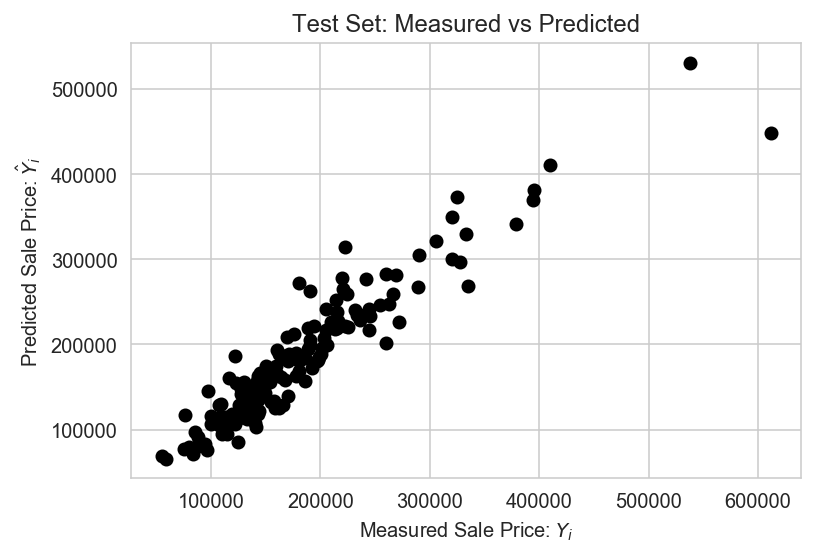

In [267]:
# Plot predictions for test data from ridge model vs actual sale prices

y_pred_ridge_test = ridge.predict(X_test_ss)

plt.scatter(y_test, y_pred_ridge_test, color='black')

plt.xlabel('Measured Sale Price: $Y_i$')
plt.ylabel('Predicted Sale Price: $\hat{Y}_i$')

plt.title('Test Set: Measured vs Predicted')

In [268]:
# Creating a dataframe with predictor coefficients for optimal ridge model

ridge_coeffs = pd.DataFrame({'features': X_train.columns,
                             'coef': ridge.coef_,
                             'abs_coef': np.abs(ridge.coef_)})

ridge_coeffs.sort_values('abs_coef', inplace=True, ascending=False)

In [269]:
# Here are the largest and most important coefficients

lasso_coeffs.head(20)

,features,coef,abs_coef
7,GrLivArea,27990.198885,27990.198885
102,BsmtQual_Gd,-13401.634151,13401.634151
103,BsmtQual_TA,-12186.269849,12186.269849
56,Neighborhood_NridgHt,11988.902321,11988.902321
55,Neighborhood_NoRidge,10176.572742,10176.572742
16,GarageCars,8032.792706,8032.792706
62,Neighborhood_StoneBr,7494.385891,7494.385891
4,YearRemodAdd,7014.987828,7014.987828
3,YearBuilt,6447.482003,6447.482003
5,TotalBsmtSF,5946.575602,5946.575602


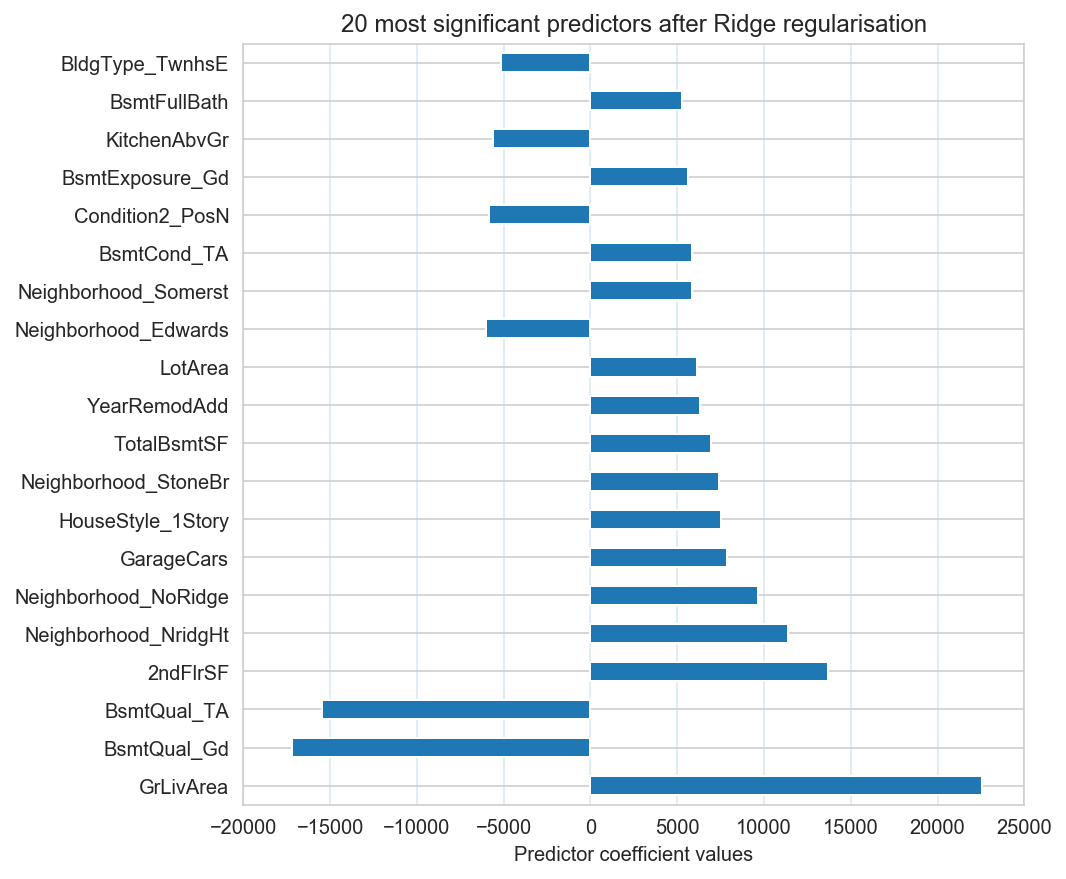

In [270]:
# Here I will graph the largest and most important coefficients

fig, ax = plt.subplots(figsize=(7,7))
title = '20 most significant predictors after Ridge regularisation'
ridge_coeffs.coef[:20].plot(kind='barh', ax=ax)
ax.set_yticklabels(ridge_coeffs.features[:20].values)
ax.set_xlabel('Predictor coefficient values')
ax.set_title(title)

ax.xaxis.grid(True, linestyle='-', which='both', color='lightblue', alpha=0.5)
ax.set_xticks(range(-20000, 30000, 5000), minor=True)
plt.show()

### Trying ElasticNet to see the Results

In [271]:
# Now I will test out Elastic Net

elastic = ElasticNetCV(cv=5)
elastic.fit(X_train_ss, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [272]:
# Here is the ElasticNet score on the training data

elastic.score(X_train_ss, y_train)

0.16505836186625056

In [273]:
# Here is the ElasticNet score on my test data

r2_elastic_test = elastic.score(X_test_ss, y_test)
r2_elastic_test

0.16495753177647732

In [274]:
# Here I am adding my testing data to the model and capturing the predictions in an array

y_pred_elastic_test = elastic.predict(X_test_ss)

In [275]:
# Here is the RMSE after ElasticNet

rmse_elastic_test = np.sqrt(mean_squared_error(y_test, y_pred_elastic_test))
rmse_elastic_test

72860.81414437498

Text(0.5, 1.0, 'Test Set: Measured vs Predicted')

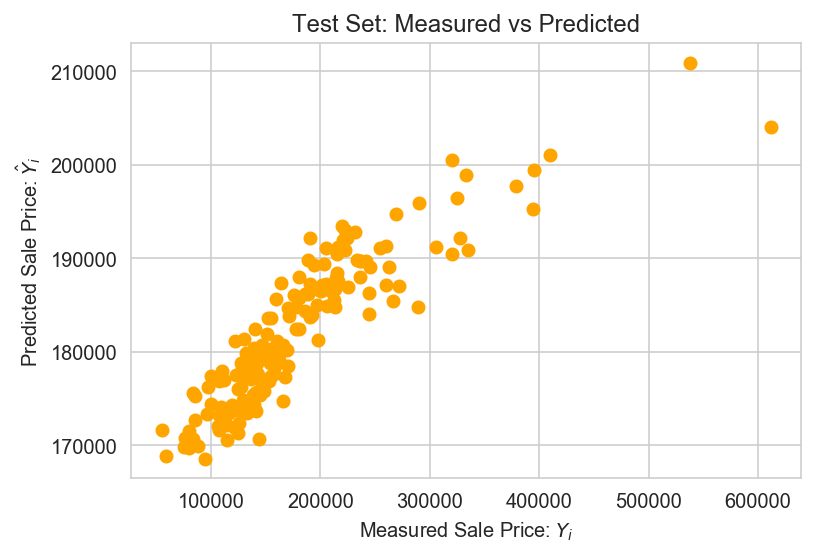

In [276]:
# Plot predictions for test data from ridge model vs actual sale prices

y_pred_elastic_test = elastic.predict(X_test_ss)

plt.scatter(y_test, y_pred_elastic_test, color='orange')

plt.xlabel('Measured Sale Price: $Y_i$')
plt.ylabel('Predicted Sale Price: $\hat{Y}_i$')

plt.title('Test Set: Measured vs Predicted')

In [277]:
# Creating a dataframe with predictor coefficients for ElasticNet model

elastic_coeffs = pd.DataFrame({'features': X_train.columns,
                             'coef': elastic.coef_,
                             'abs_coef': np.abs(elastic.coef_)})

elastic_coeffs.sort_values('abs_coef', inplace=True, ascending=False)

In [278]:
# Here are the largest and most important coefficients

elastic_coeffs.head(20)

,features,coef,abs_coef
7,GrLivArea,891.928748,891.928748
16,GarageCars,804.044903,804.044903
5,TotalBsmtSF,764.334797,764.334797
10,FullBath,693.612309,693.612309
14,TotRmsAbvGrd,661.962860,661.962860
4,YearRemodAdd,624.153160,624.153160
3,YearBuilt,624.071807,624.071807
15,Fireplaces,589.961487,589.961487
97,Foundation_PConc,587.415013,587.415013
103,BsmtQual_TA,-548.303465,548.303465


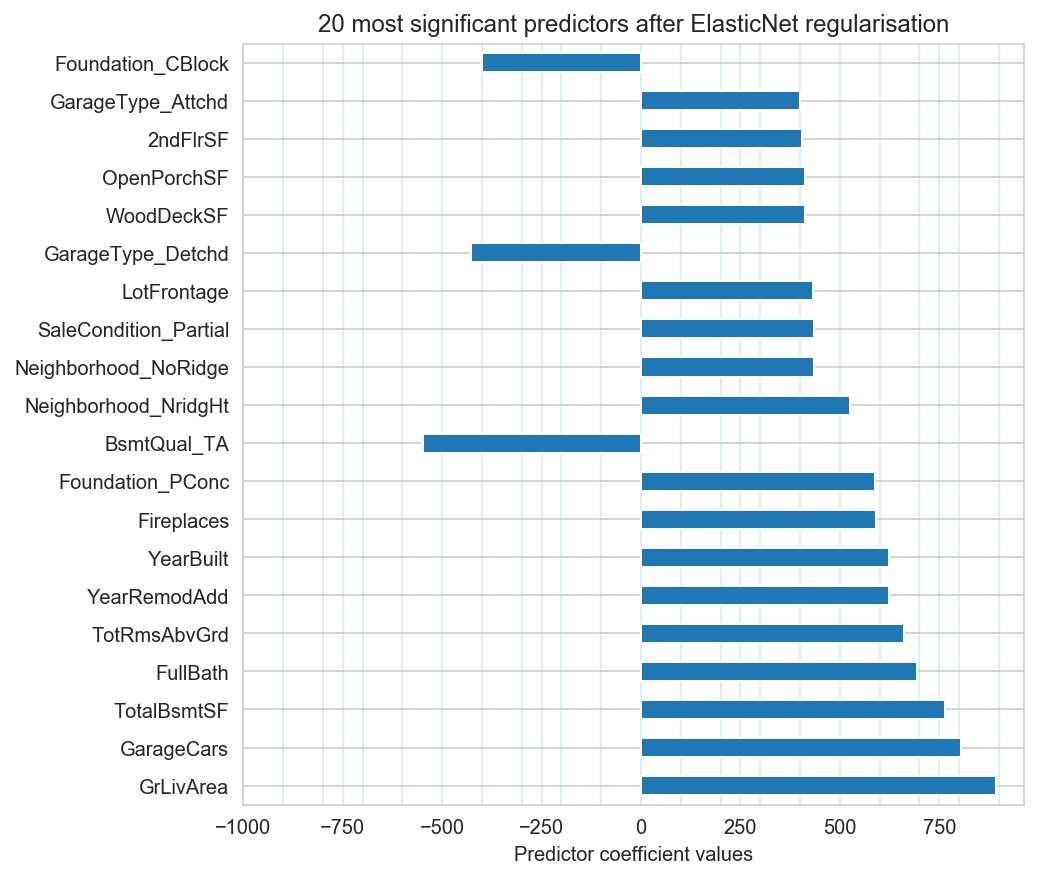

In [279]:
# Here I will graph the largest and most important coefficients

fig, ax = plt.subplots(figsize=(7,7))
title = '20 most significant predictors after ElasticNet regularisation'
elastic_coeffs.coef[:20].plot(kind='barh', ax=ax)
ax.set_yticklabels(elastic_coeffs.features[:20].values)
ax.set_xlabel('Predictor coefficient values')
ax.set_title(title)

ax.xaxis.grid(True, linestyle='-', which='both', color='lightblue', alpha=0.5)
ax.set_xticks(range(-1000, 1000, 100), minor=True)
plt.show()

### Trying GridSearch and Stochastic Gradient Descent to see the Results

In [280]:
# Setting up my gridsearch parameters.

sgd_params = {
    'loss':['squared_loss','huber'],
    'penalty':['l1','l2'],
    'alpha':np.logspace(-5,1,25)
}

sgd_reg = SGDRegressor()
sgd_reg_gs = GridSearchCV(sgd_reg, sgd_params, cv=5, verbose=False)

In [281]:
# Fitting the X and y's of my training data

sgd_reg_gs.fit(X_train_ss, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=None,
                                    shuffle=True, tol=0.001,
                                    validation_fraction=0.1, ver...
       1.00000000e-03, 1.77827941e-03, 3.16227766e-03, 5.62341325e-03,
       1.00000000e-02, 1.77827941e-02, 3.16227766e-02, 5.62341325e-02,
       1.00000000e-01, 1.77827941e-01, 3.16227766e-01, 5.62341325e-01,
       1.00000000e+00, 1.77827941e+00, 3.16227766e+00, 5.62341325e+00,
       1.00000000e+01]),
                 

In [282]:
# Here are the best paramaters

sgd_reg_gs.best_params_

{'alpha': 1.0, 'loss': 'squared_loss', 'penalty': 'l2'}

In [283]:
# Here is the score on the training data

sgd_reg_gs.best_score_

0.7733987203170907

In [284]:
sgd_reg = sgd_reg_gs.best_estimator_
sgd_reg

SGDRegressor(alpha=1.0, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [285]:
# Here is the score on the test data

r2_sgd_test = sgd_reg_gs.score(X_test_ss, y_test)
r2_sgd_test

0.824686004758346

In [286]:
# I will capture the predictions

y_pred_sgd_test = sgd_reg_gs.predict(X_test_ss)

In [287]:
# Here is the RMSE from SGD

rmse_sgd_test = np.sqrt(mean_squared_error(y_test, y_pred_sgd_test))
rmse_sgd_test

33384.74256231397

In [288]:
value_coefs = pd.DataFrame({'coef':sgd_reg.coef_,
                            'mag':np.abs(sgd_reg.coef_),
                            'pred':X_train.columns})
value_coefs.sort_values('mag', ascending=False, inplace=True)
value_coefs.head(20)

,coef,mag,pred
7,8293.226112,8293.226112,GrLivArea
56,7677.092442,7677.092442,Neighborhood_NridgHt
16,7298.184894,7298.184894,GarageCars
5,6908.408927,6908.408927,TotalBsmtSF
55,6728.635067,6728.635067,Neighborhood_NoRidge
14,5437.902893,5437.902893,TotRmsAbvGrd
4,5059.917799,5059.917799,YearRemodAdd
10,4964.637148,4964.637148,FullBath
107,4902.109502,4902.109502,BsmtExposure_Gd
15,4796.512366,4796.512366,Fireplaces


### Final Conclusion

In [289]:
print('--------------------------------------')
print('Baseline: $', round(baseline, 2))
print('--------------------------------------')
print('Linear Model RMSE: $', round(rmse_linear_test, 2))
print('Linear Model score:', round(r2_linear_test, 4)*100)
print('--------------------------------------')
print('Lasso Model RMSE: $', round(rmse_lasso_test, 2))
print('Lasso Model score:', round(r2_lasso_test, 4)*100)
print('--------------------------------------')
print('Ridge Model RMSE: $', round(rmse_ridge_test, 2))
print('Ridge Model score:', round(r2_ridge_test, 4)*100)
print('--------------------------------------')
print('ElasticNet Model RMSE: $', round(rmse_elastic_test, 2))
print('ElasticNet Model score:', round(r2_elastic_test, 4)*100)
print('--------------------------------------')
print('SGD Model RMSE: $', round(rmse_sgd_test, 2))
print('SGD Model score:', round(r2_sgd_test, 4)*100)
print('--------------------------------------')

--------------------------------------
Baseline: $ 79783.25
--------------------------------------
Linear Model RMSE: $ 28664.06
Linear Model score: 87.08
--------------------------------------
Lasso Model RMSE: $ 27228.26
Lasso Model score: 88.34
--------------------------------------
Ridge Model RMSE: $ 27044.07
Ridge Model score: 88.5
--------------------------------------
ElasticNet Model RMSE: $ 72860.81
ElasticNet Model score: 16.5
--------------------------------------
SGD Model RMSE: $ 33384.74
SGD Model score: 82.47
--------------------------------------


The results from the models are good except for ElasticNet.  Any of the other models could be used to predict future hose prices.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

### Creating my Train and Test

In [290]:
# Using the residuals from the Ridge model to create test and training targets

y_test_reno = y_test - ridge.predict(X_test_ss)
y_train_reno = y_train - lasso.predict(X_train_ss)

In [291]:
# Splitting the renovatable data into a test and train data set based on the year sold

house_renovatable_train = house_renovatable[house_renovatable['YrSold'] != 2010]
house_renovatable_test = house_renovatable[house_renovatable['YrSold'] == 2010]

In [292]:
# Creating X variables from the renovatable data set

X_test_reno = house_renovatable_test.drop(columns=['YrSold'])
X_train_reno = house_renovatable_train.drop(columns=['YrSold'])

In [293]:
# Checking the shape of my dataframe and series

print(X_test_reno.shape)
print(X_train_reno.shape)
print(y_test_reno.shape)
print(y_train_reno.shape)

(172, 107)
(1278, 107)
(172,)
(1278,)


### Fitting a Linear Model

In [294]:
# I am using the Linear Regression model from SK Learn

linear_reno = LinearRegression()

In [295]:
# I am fitting the model with the training data

linear_reno.fit(X_train_reno, y_train_reno)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [296]:
# Here I will capture an array for my predicted y values from my training data

y_pred_train_reno = linear_reno.predict(X_train_reno)
y_pred_train_reno

array([ 1519.04570228, 12770.61610597, -4816.5634544 , ...,
         357.15596455, -9368.66810442,  4209.7973159 ])

Text(0.5, 1.0, 'Training Set: Measured vs Predicted')

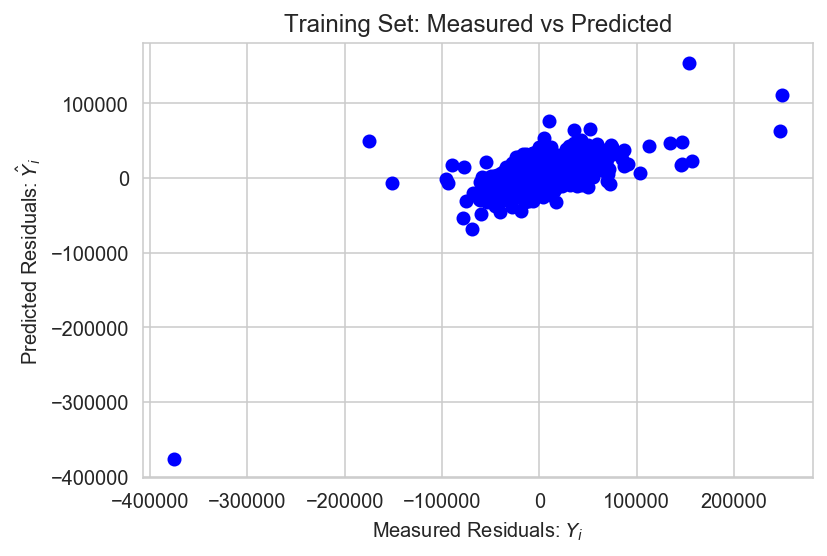

In [297]:
# Here is a scatter plot for the measured versus predicted sale prices from my training data

plt.scatter(y_train_reno, y_pred_train_reno, color='blue')

plt.xlabel('Measured Residuals: $Y_i$')
plt.ylabel('Predicted Residuals: $\hat{Y}_i$')

plt.title('Training Set: Measured vs Predicted')

In [298]:
# Here is the score from my test data

r2_test_reno = linear_reno.score(X_test_reno, y_test_reno)
r2_test_reno

0.15500209065646708

In [299]:
# Here is the RMSE from the test data

rmse_test_reno = np.sqrt(mean_squared_error(y_train_reno, y_pred_train_reno))
rmse_test_reno

23357.38713252108

### Testing the Model on Test data

In [300]:
# Here I am adding my testing data to the model and capturing the predictions in an array

y_pred_reno = linear_reno.predict(X_test_reno)

Text(0.5, 1.0, 'Test Set: Measured vs Predicted')

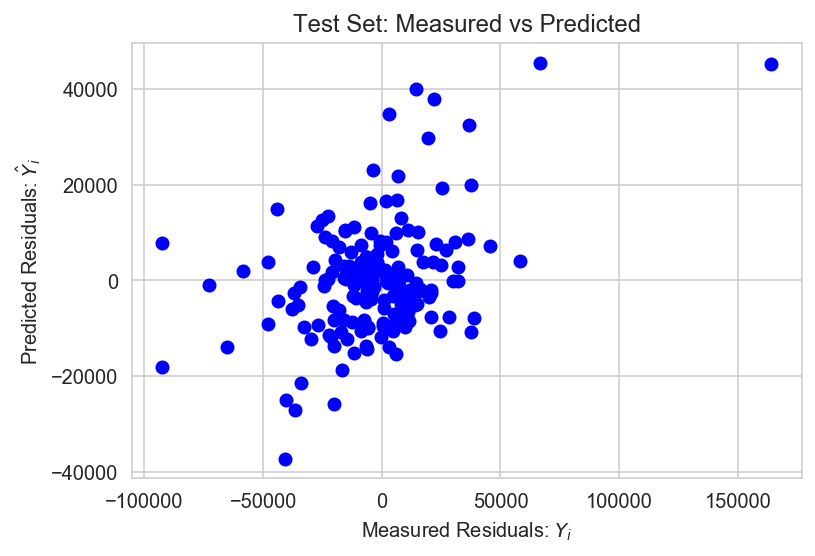

In [301]:
# Here is a scatterr plot for the measured versus predicted sale prices from my test data

plt.scatter(y_test_reno, y_pred_reno, color='blue')

plt.xlabel('Measured Residuals: $Y_i$')
plt.ylabel('Predicted Residuals: $\hat{Y}_i$')

plt.title('Test Set: Measured vs Predicted')

In [302]:
# Here is the score from my test data

r2_test_reno = linear_reno.score(X_test_reno, y_test_reno)
r2_test_reno

0.15500209065646708

In [303]:
# Here is the RMSE from the test data

rmse_test_reno = np.sqrt(mean_squared_error(y_test_reno, y_pred_reno))
rmse_test_reno

24724.141804787505

### Using Lssso to find the features with the most impact

In [304]:
# First I will use Standard Scalar to standerdsie my data

X_train_reno_ss = ss.fit_transform(X_train_reno)
X_test_reno_ss = ss.fit_transform(X_test_reno)

In [305]:
# Here I am performing a lasso regularisation as this gave a good result above

lasso_reno = LassoCV(cv=5)
lasso_reno.fit(X_train_reno_ss, y_train_reno)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [306]:
# Here is the score on my test data

lasso_reno.score(X_test_reno_ss, y_test_reno)

0.09211341082015112

In [307]:
# Creating a dataframe with predictor coefficients for optimum Lasso model

lasso_reno_coeffs = pd.DataFrame({'features': X_train_reno.columns,
                             'coef': lasso_reno.coef_,
                             'abs_coef': np.abs(lasso_reno.coef_)})

lasso_reno_coeffs.sort_values('abs_coef', inplace=True, ascending=False)

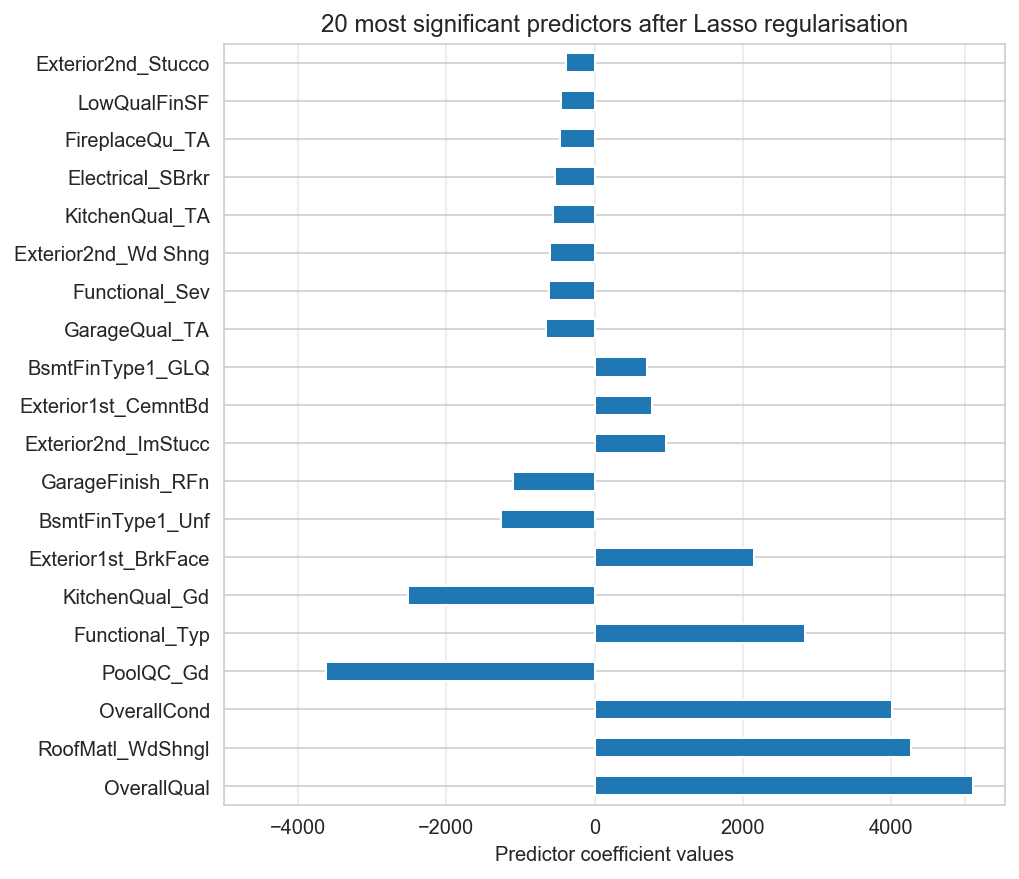

In [308]:
# Here I will graph the largest and most important coefficients

fig, ax = plt.subplots(figsize=(7,7))
title = '20 most significant predictors after Lasso regularisation'
lasso_reno_coeffs.coef[:20].plot(kind='barh', ax=ax)
ax.set_yticklabels(lasso_reno_coeffs.features[:20].values)
ax.set_xlabel('Predictor coefficient values')
ax.set_title(title)

ax.xaxis.grid(True, linestyle='-', which='both', color='lightgrey', alpha=0.5)
ax.set_xticks(range(-5000, 10000, 5000), minor=True)
plt.show()

In [309]:
# Here are the largest and most important coefficients
# This also shows the relationship between the feature and the change predicted house price.
# This could be used to estimate renovations and how much value they would add to the estimated sale price.

lasso_reno_coeffs.head(20)

,features,coef,abs_coef
0,OverallQual,5105.103791,5105.103791
13,RoofMatl_WdShngl,4272.336796,4272.336796
1,OverallCond,4015.632885,4015.632885
103,PoolQC_Gd,-3623.113714,3623.113714
85,Functional_Typ,2841.630544,2841.630544
78,KitchenQual_Gd,-2521.797796,2521.797796
16,Exterior1st_BrkFace,2152.173855,2152.173855
57,BsmtFinType1_Unf,-1261.642346,1261.642346
90,GarageFinish_RFn,-1098.491075,1098.491075
34,Exterior2nd_ImStucc,963.512025,963.512025


### Conclusion

.....................................................................................................................


The coefficiants above give an indication in dollars of the features effect on the residual (difference between the predicted price and the actual price), therefore they could be used as an indication to determine the increase in price if these features were renovated.

However as the model has a low R2 and a large RMSE compared to the residuals I dont belive the model is very accurate and would need alot more feature engineering to be improved.


.....................................................................................................................

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [310]:
# Here are the Sale Condition features

house['SaleCondition'].value_counts()

Normal     1194
Partial     125
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [311]:
house_fixed.columns

Index(['SalePrice', 'MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt',
       'YearRemodAdd', 'TotalBsmtSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       ...
       'GarageType_CarPort', 'GarageType_Detchd', 'MiscFeature_Othr',
       'MiscFeature_Shed', 'MiscFeature_TenC', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=124)

In [312]:
# First I need to remove the SaleCondition columns which were one hot encoded.

salecondition = house_fixed[['SaleCondition_Normal',
                            'SaleCondition_Partial',
                            'SaleCondition_Family',
                            'SaleCondition_Alloca',
                            'SaleCondition_AdjLand']]

In [313]:
# Here I am droping them from the house fixed dataframe

house_fixed.drop(salecondition, axis=1, inplace=True)

In [314]:
# As I have add YrSold to both my fixed and renovatable dataframes I need to drop one

house_renovatable.drop(columns='YrSold', inplace=True)

In [315]:
# Here Im joing both dataframes for my new model

condition = pd.concat([house_fixed, house_renovatable], axis=1, sort=False)

In [316]:
# Here I am copying the Sale Condition column from the original dataframe to the condition dataframe

condition['SaleCondition'] = house['SaleCondition']

In [317]:
# Now I will set the target Abnormal (target) to 1 and the rest to O

condition.replace({'SaleCondition':
                           {'Normal': 0,
                            'Partial': 0,
                            'Family': 0,                       
                            'Abnorml': 1,
                            'AdjLand': 0,
                            'Alloca': 0
                           }}, inplace=True)

In [318]:
condition['SaleCondition'].value_counts()

0    1354
1      96
Name: SaleCondition, dtype: int64

In [319]:
# Again I will split the data on pre and post 2010

train = condition[condition['YrSold'] != 2010]
test = condition[condition['YrSold'] == 2010]

In [320]:
# Setting my y and X's

y_con_train = train['SaleCondition']
y_con_test = test['SaleCondition']

X_con_train = train.drop(columns='SaleCondition')
X_con_test = test.drop(columns='SaleCondition')

### Standerdising the Data

In [321]:
# Using the Standard Scalar

X_con_train_ss = ss.fit_transform(X_con_train)
X_con_test_ss = ss.fit_transform(X_con_test)

### KNN

In [322]:
# As this is a clasification problem I will use KNN

knn = KNeighborsClassifier(n_neighbors = 5)
cross_val_score(knn, X_con_train_ss, y_con_train, cv = 10)

array([0.93023256, 0.921875  , 0.9296875 , 0.9296875 , 0.9296875 ,
       0.921875  , 0.9296875 , 0.93700787, 0.93700787, 0.92913386])

In [323]:
# Now I fitting the model to my test data

knn.fit(X_con_train_ss, y_con_train)
knn_score = knn.score(X_con_test_ss, y_con_test)
knn_score

0.9476744186046512

In [324]:
# Baseline

baseline_knn = np.max(condition['SaleCondition'].value_counts(normalize=True))
baseline_knn

0.9337931034482758

### Using Logistical Regression so I can extract the Coefficients

In [325]:
logreg = LogisticRegression()
logreg.fit(X_con_train_ss, y_con_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [326]:
# Scoring on the training data

logreg.score(X_con_train_ss, y_con_train)

0.9577464788732394

In [327]:
# Scoring on my test data

logreg_score = logreg.score(X_con_test_ss, y_con_test)
logreg_score

0.9302325581395349

In [328]:
# Here is an array of the coefficiants

logreg.coef_.shape

(1, 226)

In [329]:
# As the shape is an issue I need to run a for loop to create a list and convert back to an array

for i in logreg.coef_:
    my_list = i
    print (my_list)

[-1.57653360e+00  7.66290660e-01 -3.28572667e-01 -4.39501683e-01
  2.08194647e-01 -8.34826729e-01  4.26391030e-01  2.88320266e-01
  9.50262051e-01 -1.21526925e-02  7.77739949e-02 -1.17462910e-01
 -1.32951491e-01 -4.40401975e-02  2.27622732e-01 -1.86083531e-02
 -8.00175774e-02  8.30326312e-02  2.71285976e-01 -8.26864747e-03
 -1.89333636e-02  2.43578584e-01  3.20096257e-01  6.98746947e-01
 -7.25351397e-01  5.34279189e-02 -1.88954264e-01  9.49073680e-02
  1.23128737e-01 -5.67618736e-02 -1.99143249e-01 -2.23388771e-02
 -7.29638650e-01 -8.76635489e-02 -1.37008420e-01  2.19672810e-01
  4.69317522e-02 -2.12500053e-01 -2.37320572e-02 -8.89725394e-02
  1.42065505e-01  3.62114036e-01 -7.60743174e-02  1.51344189e-01
  5.92912127e-02  4.34881890e-01  6.42753320e-03  3.28140604e-01
  2.64408974e-02  4.65364926e-02 -6.09195752e-02  1.04494549e-01
  1.20499421e-01  5.93879940e-01  1.75114546e-01  4.94614368e-01
  5.07706880e-01 -6.44409220e-01  3.44119722e-01  2.16629713e-02
  2.01334545e-01  2.07326

In [330]:
# See now all better

coef = pd.Series(my_list)
coef.shape

(226,)

In [331]:
# Same as the columns

X_con_train.columns.shape

(226,)

In [332]:
# Creating a dataframe with predictor coefficients from Logistical Regression

logreg_coeffs = pd.DataFrame({'features': X_con_train.columns,
                             'coef': coef,
                             'abs_coef': np.abs(coef)})

logreg_coeffs.sort_values('abs_coef', inplace=True, ascending=False)

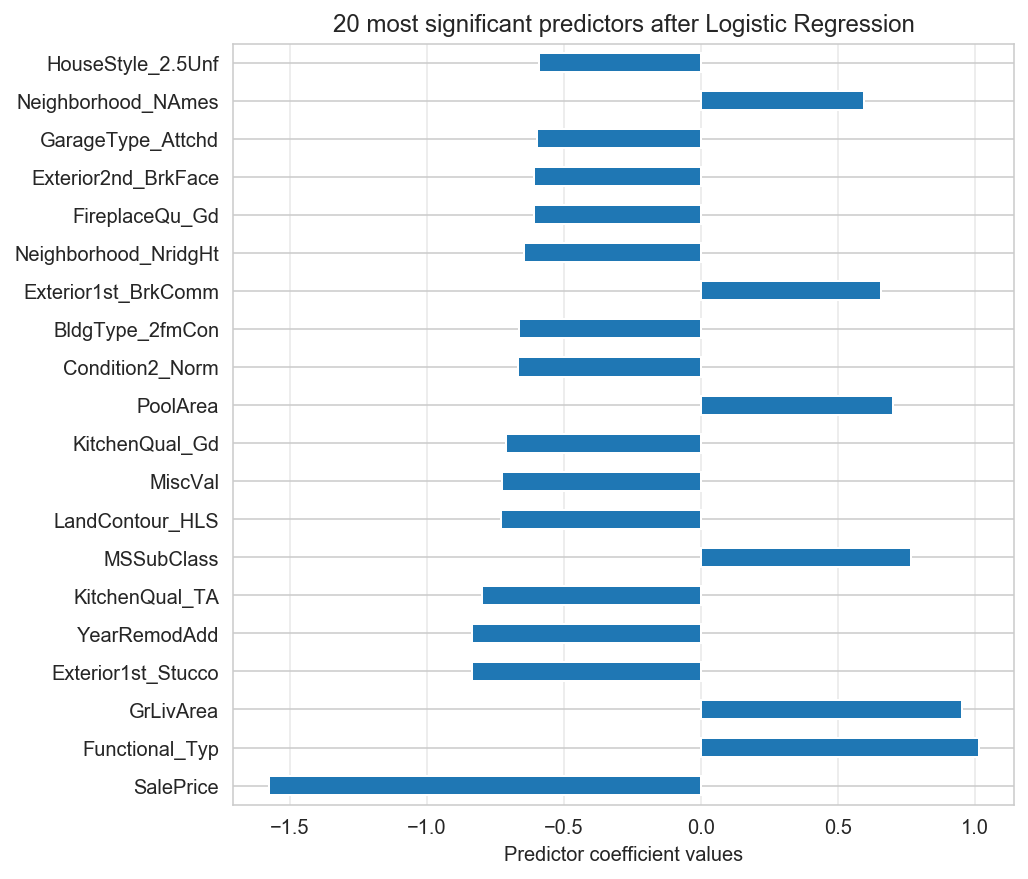

In [333]:
# Here I will graph the largest and most important coefficients

fig, ax = plt.subplots(figsize=(7,7))
title = '20 most significant predictors after Logistic Regression'
logreg_coeffs.coef[:20].plot(kind='barh', ax=ax)
ax.set_yticklabels(logreg_coeffs.features[:20].values)
ax.set_xlabel('Predictor coefficient values')
ax.set_title(title)

ax.xaxis.grid(True, linestyle='-', which='both', color='lightgrey', alpha=0.5)
ax.set_xticks(range(50, 10, 50), minor=True)
plt.show()

In [334]:
logreg_coeffs.head(20)

,features,coef,abs_coef
0,SalePrice,-1.576534,1.576534
204,Functional_Typ,1.012978,1.012978
8,GrLivArea,0.950262,0.950262
143,Exterior1st_Stucco,-0.835247,0.835247
5,YearRemodAdd,-0.834827,0.834827
198,KitchenQual_TA,-0.800052,0.800052
1,MSSubClass,0.766291,0.766291
32,LandContour_HLS,-0.729639,0.729639
24,MiscVal,-0.725351,0.725351
197,KitchenQual_Gd,-0.709305,0.709305


### Conculsion

In [336]:
print('--------------------------------------')
print('Baseline:', round(baseline_knn, 4)*100)
print('--------------------------------------')
print('KNN score:', round(knn_score, 4)*100)
print('Logistic score:', round(logreg_score, 4)*100)
print('--------------------------------------')

--------------------------------------
Baseline: 93.38
--------------------------------------
KNN score: 94.77
Logistic score: 93.02
--------------------------------------


.....................................................................................................................

The issue is KNN produces a score which is higher than the baseline however there are no coefficiants.
However with Logistic Regression I can pull the coefficiants however the score is less than the baseline.


.....................................................................................................................